<a href="https://colab.research.google.com/github/LuciusBushnaq/PhDQCD/blob/main/FlowModels/L%C3%BCscher_Schwinger_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TORCH VERSION: 1.13.1+cu116
TORCH DEVICE: cuda
Loading pre-trained model
Skipping training
Accept rate: 0.12973416666666668


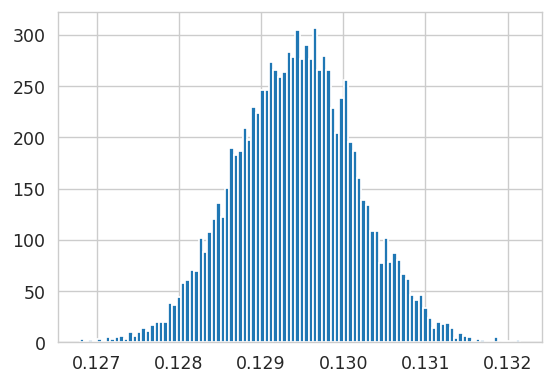

Accept rate=0.12942684466666665 +/- 0.0007420624695658864


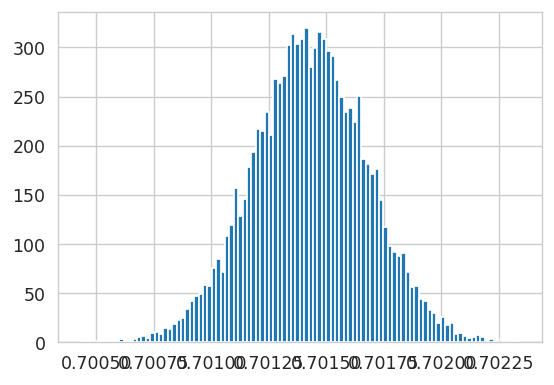

average plaquette = 0.7014286518096924 +/- 0.00024805532302707434


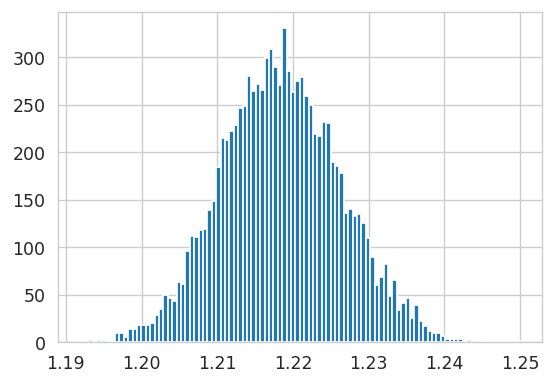

Topological susceptibility = 1.2184752225875854 +/- 0.007828428409993649


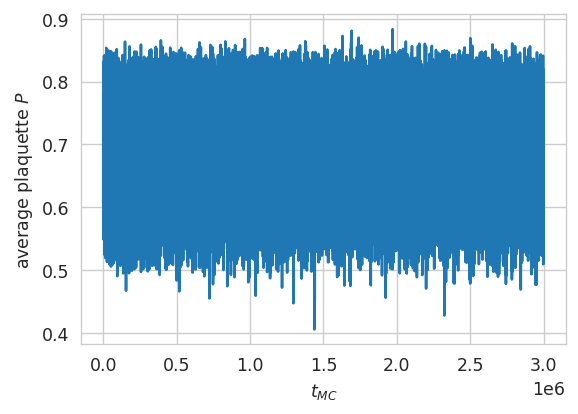

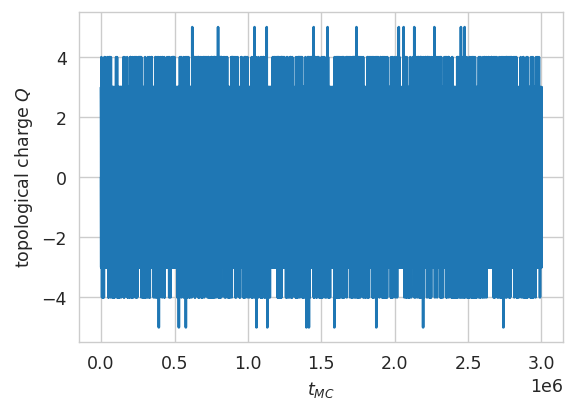

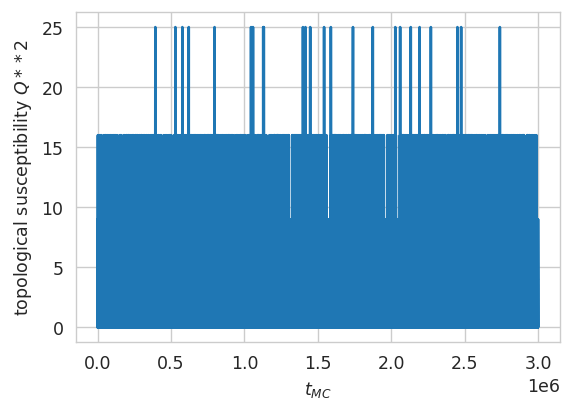

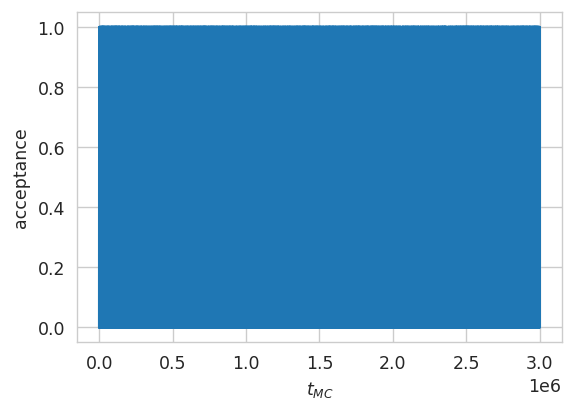

In [ ]:
import base64
import io
import pickle
import numpy as np
import torch
import pandas as pd
import cmath
print(f'TORCH VERSION: {torch.__version__}') 
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'): 
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
    
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

pd.options.display.max_seq_items = 20000

if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double 
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

#Useful general functions
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi
def grab(var):
    return var.detach().cpu().numpy()
#Useful torch.roll for field with AP boundary conditions in time direction
def roll_AP(x,s,d):
    if (d==2):
        assert s==1 or s==-1, 'roll_AP can only handle shifts by one lattice site' 
        x_s=torch.roll(x, s, d)
        if (s==1):
            x_s[:,:,0]=-x_s[:,:,0]
        if (s==-1):
            x_s[:,:,-1]=-x_s[:,:,-1]
        return x_s
    else:
        return torch.roll(x, s, d)

def roll_AP_pt(x,s,d):
    if (d==3):
        assert s==1 or s==-1, 'roll_AP can only handle shifts by one lattice site' 
        x_s=torch.roll(x, s, d)
        if (s==1):
            x_s[:,:,:,0]=-x_s[:,:,:,0]
        if (s==-1):
            x_s[:,:,:,-1]=-x_s[:,:,:,-1]
        return x_s
    else:
        return torch.roll(x, s, d)
        
    
    
    

#Stuff for pretty plots
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 0.4)
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy plt.grid(False)
    plt.ylabel('ESS')
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    display_id = display(fig, display_id=True)
    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )
def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window
def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id): 
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y))) 
    Y = history['loss']
    Y = moving_average(Y, window=15) 
    loss_line[0].set_ydata(np.array(Y)) 
    loss_line[0].set_xdata(np.arange(len(Y))) 
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2) 
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)    
# init weights
def set_weights_xavier(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.xavier_normal_(m.weight, gain=0.5) 
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.xavier_normal_(m.bias, gain=0.5) 
def set_weights_kaiming(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.kaiming_uniform_(m.weight, gain=nn.init.calculate_gain('leaky_relu')) 
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.kaiming_uniform_(m.bias, gain=nn.init.calculate_gain('leaky_relu')) 

    
#General stuff for training    
def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q
def apply_flow_to_prior(prior_U, prior_x, coupling_layers, *, batch_size):
    U = prior_U.sample_n(batch_size)
    x = prior_x.sample_n(batch_size)
    logq_U = prior_U.log_prob(U)
    logq_x = prior_x.log_prob(x)
    assert not torch.isnan(logq_U).any(), f"NaN in the prior logq_U={logq_U[0]}"
    assert not torch.isinf(logq_x).any(), f"inf in the prior logq_x={logq_x[0]}"
    #print(f'log_x {logq_x[0]}')
    #print(f'log_U {logq_U[0]}')
    logq=logq_U+logq_x
    assert not torch.isnan(logq).any(), f"NaN in the prior logq={logq[0]}"
    #logq=logq_U
    i=0
    for layer in coupling_layers:
        U, x, logJ = layer.forward(U, x)

        logq = logq - logJ
        #print((logJ[0],i))
        i=i+1
    return U, x, logq
def train_step(model, action, loss_fn, optimizer, metrics): 
    layers, prior_U, prior_x = model['layers'], model['prior_U'], model['prior_x']
    optimizer.zero_grad()
    U, x, logq = apply_flow_to_prior(prior_U, prior_x, layers, batch_size=batch_size)
    logp, E = action(U,x)
    logp=-logp
    E=-E
    #assert not torch.isinf(logp).any(), f"inf in the logp={logp[0]}"
    #assert not torch.isinf(logq).any(), f"inf in the logq={logq[0]}"
    loss = calc_dkl(logp, logq)
    #assert not torch.isinf(loss).any(), f"inf in the loss={loss[0]}"
    loss.backward()
    optimizer.step()
    metrics['loss'].append(grab(loss)) 
    metrics['logp'].append(grab(logp)) 
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))
    metrics['E'].append(grab(E))
    metrics['x'].append(grab(x[0]))
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg
def print_metrics(history, avg_last_N_epochs): 
    print(f'== Era {era} | Epoch {epoch} metrics ==') 
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:]) 
        print(f'\t{key} {avgd:g}')     
#Our prior
class Fermion_nf(torch.nn.Module): 
  """Gaussian normal draw samples""" 
  def __init__(self, a, b, c, d):
    super().__init__()
    self.distreal= torch.distributions.normal.Normal(a, b)
    self.distimag= torch.distributions.normal.Normal(c, d)
  def log_prob(self, x):
    axes = range(1, len(x.shape))
    return torch.sum( self.distreal.log_prob(x.real)+self.distimag.log_prob(x.imag), dim=tuple(axes) ) 
  def sample_n(self, batch_size):
    real=self.distreal.sample((batch_size,))
    imag=self.distimag.sample((batch_size,))
    return torch.complex(real,imag)

class MultivariateUniform(torch.nn.Module): 
    """Uniformly draw samples from [a,b]""" 
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        return self.dist.sample((batch_size,))
    
#Stuff for calculating U(1) theory
def compute_u1_plaq(links, mu, nu):
    """Compute U(1) plaquettes in the (mu,nu) plane given `links` = arg(U)""" 
    return (links[:,mu] + torch.roll(links[:,nu], -1, mu+1)
            - torch.roll(links[:,mu], -1, nu+1) - links[:,nu])
class TestAction:
  def __init__(self, prior_U,prior_x):
    self.prior_U=prior_U
    self.prior_x=prior_x
  def __call__(self, U,x):
    gauge_action_density=-prior_U.log_prob(U)
    Fermion_action_density=-prior_x.log_prob(x)
    return gauge_action_density+Fermion_action_density, gauge_action_density


class U1GaugeAction:
    def __init__(self, beta):
        self.beta = beta
    def __call__(self, cfgs):
        Nd = cfgs.shape[1]
        action_density = 0
        for mu in range(Nd):
            for nu in range(mu+1,Nd):
                action_density = action_density + torch.cos(
                    compute_u1_plaq(cfgs, mu, nu))
        return -self.beta * torch.sum(action_density, dim=tuple(range(1,Nd+1)))
    
#Stuff for calculating U(1) interaction  
def pauli(mu,field):
    pauli=[0,0,0]
    pauli[0]=torch.complex(torch.tensor([[0.0,1.0],[1.0,0.0]]),torch.zeros(2,2))
    pauli[1]=torch.complex(torch.zeros(2,2),torch.tensor([[0.0,-1.0],[1.0,0.0]]))
    pauli[2]=torch.complex(torch.tensor([[1.0,0.0],[0.0,-1.0]]),torch.zeros(2,2))

    field=field.unsqueeze(-1)
    return np.sign(mu)*torch.matmul(pauli[abs(mu)],field).squeeze(-1)
def spinstruct(mu,x):
    if mu==2:
        return pauli(mu,x)
    else: 
        return pauli(2,x-pauli(mu,x))

    
def compute_Q(links,x,m):
        """Compute gamma_5 (pauli_3) times the normalised Dirac operator for the input""" 
        result= ((m+2.0)/(m+4.0))*spinstruct(2,x)
        for mu in range(0,links.shape[1]):
            forw=torch.unsqueeze(links[:,mu],3)*spinstruct(mu,roll_AP(x,-1,mu+1))
            back=torch.unsqueeze(torch.conj(torch.roll(links[:,mu], +1, mu+1)),3)*spinstruct(-mu,roll_AP(x,+1,mu+1))
            result+=-0.5*(forw+back)/(m+4.0)
        #assert not torch.isnan(result).any(), f"NaN in the compute_d={result[0]}"
        #assert not torch.isinf(result).any(), f"inf in the compute_d={result[0]}"
        return result


def compute_parallel_transport(x,links, parity):
  temp=[]
  temp.append(torch.select(x,4,parity))
  for mu in range(0,links.shape[1]):
    for s in range(0,x.shape[4]):
      temp.append(torch.unsqueeze(links[:,mu],1)*roll_AP_pt(torch.select(x,4,s),-1,mu+2))
      temp.append(torch.unsqueeze(torch.conj(torch.roll(links[:,mu], +1, mu+1)),1)*roll_AP_pt(torch.select(x,4,s),+1,mu+2))
  return torch.stack(temp,dim=4)

class TotalAction(U1GaugeAction):
    def __init__(self, beta, S_f,n_f):
        super().__init__(beta)
        self.S_f=S_f
    def __call__(self, U, x):
        Nd = U.shape[1]
        gauge_action_density = super().__call__(U)
        #assert not torch.isinf(gauge_action_density).any(), f"inf in the gauge_action={gauge_action_density[0]}"
        links=torch.polar(torch.ones(U.shape),U)
        Fermion_action=0
        for k in range(0,n_f):
          Fermion_action+=(compute_Q(links,x[:,k],self.S_f[k][2])-self.S_f[k][0]*x[:,k]).abs()**2+self.S_f[k][1]*x[:,k].abs()**2
        Fermion_action_density=torch.sum(Fermion_action, dim=tuple(range(1,Nd+2)))
        #assert not torch.isinf(Fermion_action_density).any(), f"inf in the gauge_action={Fermion_action_density[0]}"
        return gauge_action_density+Fermion_action_density, gauge_action_density

#Our convnet setup function
def make_conv_net(*, hidden_sizes, dilation_sizes, kernel_size, in_channels, out_channels, use_final_tanh): 
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0') 
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0' 
    net = []
    for i in range(len(sizes) - 1):
      padding_size = (  (kernel_size+(kernel_size-1)*(dilation_sizes[i]-1)) // 2)
      net.append(torch.nn.Conv2d(
          sizes[i], sizes[i+1], kernel_size, padding=padding_size, dilation=dilation_sizes[i], stride=1, padding_mode='circular'))
      if i != len(sizes) - 2:
            net.append(torch.nn.ELU())
      else:
          if use_final_tanh:
              net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)


#Our gauge invariant affine coupling layer for U(1)
class GaugeEquivCouplingLayer(torch.nn.Module):
    """U(1) gauge equiv coupling layer defined by `plaq_coupling` acting on plaquettes.""" 
    def __init__(self, *, lattice_shape, mask_mu, mask_off, plaq_coupling):
        super().__init__()
        link_mask_shape = (len(lattice_shape),) + lattice_shape
        self.active_mask = make_2d_link_active_stripes(link_mask_shape, mask_mu, mask_off)
        self.plaq_coupling = plaq_coupling
    def forward(self, U,x):
        plaq = compute_u1_plaq(U, mu=0, nu=1)
        new_plaq, logJ = self.plaq_coupling(plaq)
        delta_plaq = new_plaq - plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        fU = self.active_mask * torch_wrap(delta_links + U) + (1-self.active_mask) * U
        assert not torch.isnan(logJ).any(), f"NaN in the gauge logJ={logJ[0]}"
        assert not torch.isinf(logJ).any(), f"inf in the gauge logJ={logJ[0]}"
        return fU, x, logJ
    def reverse(self, fU,x):
        new_plaq = compute_u1_plaq(x, mu=0, nu=1)
        plaq, logJ = self.plaq_coupling.reverse(new_plaq)
        delta_plaq = plaq - new_plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        U = self.active_mask * torch_wrap(delta_links + fU) + (1-self.active_mask) * fU 
        return U, x, logJ


class FermionCouplingLayer(torch.nn.Module):
    def __init__(self, *, x_shape, parity_l, parity_s, A_coupling,B_coupling,k,action):
        super().__init__()
        self.parity_s=parity_s
        self.active_mask = make_checker_mask_f(x_shape, parity_l,parity_s, k=k)
        self.logJ_mask = make_checker_mask((x_shape[1],x_shape[2]), parity=parity_l)
        self.A_coupling = A_coupling
        self.B_coupling = B_coupling
        self.k=k
        self.a=action[0]*torch.ones((x_shape[1],x_shape[1]))
        self.b=action[1]*torch.ones((x_shape[1],x_shape[1]))
    def forward(self, U, x):
        plaq = compute_u1_plaq(U, mu=0, nu=1)
        links = torch.polar(torch.ones(U.shape),U)

        T = compute_parallel_transport(x,links,1-self.parity_s)
        A= self.A_coupling(stack_f(plaq,self.a,self.b))
        B= self.B_coupling(stack_f(plaq,self.a,self.b))

        A_c=torch.exp(torch.complex(A[:,0],A[:,1]))
        #test
        #A_c=torch.complex(torch.ones(A_c.shape, dtype=torch.float),torch.ones(A_c.shape, dtype=torch.float))
        B_c=torch.complex(B[:,0:9],B[:,9:18])
        B_c=B_c.permute(0,2,3,1)
        #B_c=B_c.reshape(B.size(0),x_shape[1],x_shape[2],x_shape[3],4*x_shape[3])
        #test
        #B_c=torch.complex(0.1*torch.ones(B_c.shape, dtype=torch.float),0.1*torch.ones(B_c.shape, dtype=torch.float))
        #fx_active= self.active_mask * torch.matmul(A_c.unsqueeze(1),x.unsqueeze(-1)).squeeze(-1)
        fx_active= self.active_mask * ((A_c.unsqueeze(1)).unsqueeze(-1))*x
        fT=self.active_mask*(torch.matmul((B_c.unsqueeze(1)).unsqueeze(-2),T.unsqueeze(-1)).squeeze(-1))
        #fT=self.active_mask*B_c.unsqueeze(1)*T
        fx=(1-self.active_mask)*x+fx_active+fT
        local_logJ = 2.0*self.logJ_mask*torch.log(torch.abs(A_c))
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        assert not torch.isnan(logJ).any(), f"NaN in the fermion logJ={logJ[0]}"
        assert not torch.isinf(logJ).any(), f"inf in the fermion logJ={logJ[0]}"
        return U, fx, logJ
    

    
#Masking patterns for the U(1) layers and a small test for them    
def make_2d_link_active_stripes(shape, mu, off): 
    """
    Stripes mask looks like in the `mu` channel (mu-oriented links)::
    10001000100 
    10001000100 
    10001000100 
    10001000100
    where vertical is the `mu` direction, and the pattern is offset in the nu
    direction by `off` (mod 4). The other channel is identically 0.
    """
    assert len(shape) == 2+1, 'need to pass shape suitable for 2D gauge theory' 
    assert shape[0] == len(shape[1:]), 'first dim of shape must be Nd'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[mu,:,0::4] = 1
    elif mu == 1:
        mask[mu,0::4] = 1
    nu = 1-mu
    mask = np.roll(mask, off, axis=nu+1)
    return torch.from_numpy(mask.astype(float_dtype)).to(torch_device)

def make_single_stripes(shape, mu, off): 
    """
    10001000100 
    10001000100 
    10001000100 
    10001000100
    where vertical is the `mu` direction. Vector of 1 is repeated every 4.
    The pattern is offset in perpendicular to the mu direction by `off` (mod 4). 
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
    elif mu == 1:
        mask[0::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)
def make_double_stripes(shape, mu, off): 
    """
    Double stripes mask looks like::
    11001100 
    11001100 
    11001100 
    11001100
    where vertical is the `mu` direction. The pattern is offset in perpendicular to the mu direction by `off` (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
        mask[:,1::4] = 1
    elif mu == 1:
        mask[0::4] = 1
        mask[1::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)
def make_plaq_masks(mask_shape, mask_mu, mask_off):
    mask = {}
    mask['frozen'] = make_double_stripes(mask_shape, mask_mu, mask_off+1) 
    mask['active'] = make_single_stripes(mask_shape, mask_mu, mask_off) 
    mask['passive'] = 1 - mask['frozen'] - mask['active']
    return mask

#Checkerboard Masking pattern for the fermions
def make_checker_mask(shape, parity,):
    checker = torch.ones(shape, dtype=torch.uint8)-parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

def make_checker_mask_f(shape, parity_l,parity_s, k):
    checker = torch.zeros(shape, dtype=torch.uint8)
    checker[k,1::2, ::2,parity_s] = 1-parity_l
    checker[k,::2, 1::2,parity_s] = 1-parity_l
    checker[k,::2, ::2,parity_s] = parity_l
    checker[k,1::2, 1::2,parity_s] = parity_l
    return checker.to(torch_device)

#Helper functions for the inner plaquette coupling layer
def tan_transform(x, s):
    #assert not torch.isnan(torch.exp(s)).any(), f"NaN in the exp(s)={torch.exp(s)[0],s[0]}"
    #assert not torch.isinf(torch.exp(s)).any(), f"inf in the exp(s)={torch.exp(s)[0],s[0]}"
    #assert not torch.isnan(2*torch.atan(torch.tan(x/2)*torch.exp(s))).any(), f"NaN in the tan={2*torch.atan(torch.tan(x/2)*torch.exp(s))[0]}"
    #assert not torch.isinf(2*torch.atan(torch.tan(x/2)*torch.exp(s))).any(), f"inf in the tan={2*torch.atan(torch.tan(x/2)*torch.exp(s))[0]}"
    return 2*torch.atan(torch.tan(x/2)*torch.exp(s))
def tan_transform_logJ(x, s):
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)
def mixture_tan_transform(x, s):
    assert len(x.shape) == len(s.shape), \
    f'Dimension mismatch between x and s {x.shape} vs {s.shape}' 
    mean=torch.mean(tan_transform(x, s), dim=1, keepdim=True)
    #assert not torch.isnan(mean).any(), f"NaN in the mean={mean[0]}"
    #assert not torch.isinf(mean).any(), f"inf in the mean={mean[0]}"
    return mean
def mixture_tan_transform_logJ(x, s):
    assert len(x.shape) == len(s.shape), \
    f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

def invert_transform_bisect(y, *, f, tol, max_iter, a=(-1)*np.pi, b=np.pi):
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance ' f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
        print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}') 
        return mid_x
    
def stack_cos_sin(x):
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

def stack_f(x,a,b):
    a_x=(a.unsqueeze(0)).expand(x.size(0),-1,-1)
    b_x=(b.unsqueeze(0)).expand(x.size(0),-1,-1)
    return torch.stack((torch.cos(x), torch.sin(x),a_x,b_x), dim=1)

#The inner plaquette coupling layer
class NCPPlaqCouplingLayer(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_mu, mask_off,
        inv_prec=1e-6, inv_max_iter=1000):
        super().__init__()
        assert len(mask_shape) == 2, (
        f'NCPPlaqCouplingLayer is implemented only in 2D, ' 
        f'mask shape {mask_shape} is invalid')
        self.mask = make_plaq_masks(mask_shape, mask_mu, mask_off)
        self.net = net
        self.inv_prec = inv_prec
        self.inv_max_iter = inv_max_iter
        
    def forward(self, P):
        P2 = self.mask['frozen'] * P
        net_out = self.net(stack_cos_sin(P2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels' 
        s, t = net_out[:,:-1], net_out[:,-1]
        P1 = self.mask['active'] * P
        P1 = P1.unsqueeze(1)
        #assert not torch.isnan(s).any(), f"NaN in the plaquette s={s[0]}"
        #assert not torch.isinf(s).any(), f"inf in the plaquette s={s[0]}"
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(P1, s) 
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        fP1 = self.mask['active'] * mixture_tan_transform(P1, s).squeeze(1)
        
        fP = (
            self.mask['active'] * (fP1 + t) + 
            self.mask['passive'] * P + 
            self.mask['frozen'] * P)
        #assert not torch.isnan(P).any(), f"NaN in the plaq={P[0]}"
        #assert not torch.isinf(P).any(), f"inf in the plaq={P[0]}"
        #assert not torch.isnan(logJ).any(), f"NaN in the logJ={logJ[0]}"
        #assert not torch.isinf(logJ).any(), f"inf in the logJ={logJ[0]}"
        return fP, logJ
    def reverse(self, fP):
        fP2 = self.mask['frozen'] * fP
        net_out = self.net(stack_cos_sin(fP2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels' 
        s, t = net_out[:,:-1], net_out[:,-1]
        P1 = self.mask['active'] * (fP - t).unsqueeze(1)
        transform = lambda x: self.mask['active'] * mixture_tan_transform(x, s) 
        P1 = invert_transform_bisect(P1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter) 
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(P1, s) 
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = -torch.sum(local_logJ, dim=axes)
        P1 = P1.squeeze(1)
        P=(
            self.mask['active'] * P1 + 
            self.mask['passive'] * fP + 
            self.mask['frozen'] * fP2)
        return P, logJ
    
#Our actual function for the whole thing for the coupled U(1) and coupled fermion
def make_phi4u1_equiv_layers(*, n_layers_g, n_layers_f, n_mixture_comps, lattice_shape, x_shape, hidden_sizes, dilation_sizes, kernel_size,n_f,f_S):
    layers = []
    
    out_channels = n_mixture_comps + 1 # for mixture s and t, respectively 
    out_channels_A=2 # (spin)x(spin) complex number
    out_channels_B=18 # (1)x(2*dimension*spin+1) complex matrix
    for i in range(n_layers_g):
        in_channels = 2 # P - > (cos(P), sin(P))
        mu = i % 2
        offU = (i//2) % 4
        net_plaq = make_conv_net(in_channels=in_channels, out_channels=out_channels,hidden_sizes=hidden_sizes[0], dilation_sizes=dilation_sizes[0], kernel_size=kernel_size,use_final_tanh=False)
        
        plaq_coupling = NCPPlaqCouplingLayer(net_plaq, mask_shape=lattice_shape, mask_mu=mu, mask_off=offU)
        link_coupling = GaugeEquivCouplingLayer(lattice_shape=lattice_shape, mask_mu=mu, mask_off=offU,plaq_coupling=plaq_coupling)
        
        layers.append(link_coupling)
    for j in range(n_layers_f):
      in_channels = 4 # P - > (cos(P), sin(P)), a, b
      parity_s = j % 2
      parity_l = (j//2) % 2
      net_A=make_conv_net(in_channels=in_channels, out_channels=out_channels_A,hidden_sizes=hidden_sizes[1], dilation_sizes=dilation_sizes[1],kernel_size=kernel_size,use_final_tanh=False)
      net_B=make_conv_net(in_channels=in_channels, out_channels=out_channels_B,hidden_sizes=hidden_sizes[2], dilation_sizes=dilation_sizes[2],kernel_size=kernel_size,use_final_tanh=False)
      for k in range(n_f):
        fermion_coupling = FermionCouplingLayer(x_shape=x_shape, parity_l=parity_l,parity_s=parity_s,A_coupling=net_A,B_coupling=net_B,k=k,action=f_S[k])
        layers.append(fermion_coupling)

    return torch.nn.ModuleList(layers)

#polynomial root setup
def naivepolygen(n_f,m_f):
  f_S=[]
  for i in range(1,n_f+1):
    z=1.0-np.exp(2j*i*np.pi/(n_f+1.0))
    sqz=cmath.sqrt(z)
    if z.imag<=0:
      sqz=-sqz
    f_S.append([sqz.real,(sqz.imag)**2,m_f])
  return f_S


#MCMC and observables functions

def serial_sample_generator(model, action, L, beta, batch_size, N_samples): 
    layers, prior_U, prior_x = model['layers'], model['prior_U'], model['prior_x']
    layers.eval()
    U, x, E, logq, logp = None, None, None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            with torch.no_grad():
              U, x, logq = apply_flow_to_prior(prior_U, prior_x, layers, batch_size=batch_size) 
              logp, E = action(U,x)
              logp=-logp
              E=-E/(beta*L*L)
              Q=topo_charge(U)
        yield E[batch_i], logq[batch_i], logp[batch_i], Q[batch_i]

def sample_generator_new(beta, prior_U, prior_x, layers, batch_size): 
  with torch.no_grad():
    U, x, logq = apply_flow_to_prior(prior_U, prior_x, layers, batch_size=batch_size) 
    logp, E = action(U,x)
    logp=-logp
    E=-E/(beta*L*L)
    Q=topo_charge(U)
  return grab(logp), grab(logq), grab(E), grab(Q)

def make_mcmc_ensemble(model, action, L, beta, batch_size, N_samples):
    history = {
        'E' : [], 
        'logq' : [], 
        'logp' : [], 
        'accepted' : [],
        'Q' : []

    }  
    # build Markov chain
    sample_gen = serial_sample_generator(model, action, L, beta, batch_size, N_samples)
    for new_E, new_logq, new_logp, new_Q in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere 
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq)) 
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_E = history['E'][-1] 
                new_Q = history['Q'][-1] 
                new_logp = last_logp 
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp) 
        history['logq'].append(new_logq) 
        history['E'].append(new_E) 
        history['accepted'].append(accepted)
        history['Q'].append(new_Q)
    return history


def make_mcmc_ensemble_new(model, action, L, beta, batch_size, N_batches):
  history = {
    'E' : [], 
    'logq' : [], 
    'logp' : [], 
    'accepted' : [],
    'Q' : []
  }  
  layers, prior_U, prior_x = model['layers'], model['prior_U'], model['prior_x']
  layers.eval()

  # build Markov chain
  for i in range(N_batches):
    logp, logq, E, Q=sample_generator_new(beta, prior_U, prior_x, layers, batch_size=batch_size)
    for j in range(batch_size):
      if len(history['logp']) == 0:
        # always accept first proposal, Markov chain must start somewhere 
        accepted = True
        new_E=E[j]
        new_Q=Q[j]
        new_logp=logp[j]
        new_logq=logq[j]
      else:
        # Metropolis acceptance condition
        last_logp = history['logp'][-1]
        last_logq = history['logq'][-1]
        p_accept = np.exp((logp[j] - logq[j]) - (last_logp - last_logq)) 
        p_accept = min(1, p_accept)
        draw = np.random.rand(1) # ~ [0,1]
        if draw < p_accept:
          accepted = True
          new_E=E[j]
          new_Q=Q[j]
          new_logp=logp[j]
          new_logq=logq[j]
        else:
          accepted = False
          new_E = history['E'][-1] 
          new_Q = history['Q'][-1] 
          new_logp = last_logp 
          new_logq = last_logq
      # Update Markov chain
      history['logp'].append(new_logp) 
      history['logq'].append(new_logq) 
      history['E'].append(new_E) 
      history['Q'].append(new_Q)
      history['accepted'].append(accepted)
  return history

def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    
    plt.figure(figsize=(5,3.5), dpi=125)
    plt.hist(boots,bins=100)
    plt.show()
    return np.mean(boots), np.std(boots)

def topo_charge(x):
    P01 = torch_wrap(compute_u1_plaq(x, mu=0, nu=1))
    axes = tuple(range(1, len(P01.shape)))
    return torch.sum(P01, dim=axes) / (2*np.pi)


#Actual training

# Theory

# Action
L=8
n_f=10
lattice_shape = (L,L)
link_shape = (2,L,L)
x_shape = (n_f,L,L,2)
beta = 2.0
f_S=naivepolygen(n_f,-0.11)
#Neural net hyperparameters
n_layers_g = 24
n_layers_f = 16
n_s_nets = 2
#L16n8m-011- runs with no prefix
hidden_sizes = [[32,32],[32,32],[32,32]]
dilation_sizes= [[1,2,3],[1,1,1],[1,1,1]]
#L16n8m-011- runs with prefix [24,24,24,24] fermion
#hidden_sizes = [[32,32],[24,24,24,24],[24,24,24,24]]
#dilation_sizes= [[1,2,3],[1,1,1,1,1],[1,1,1,1,1]]
#L16n8m-011-nodil runs
#hidden_sizes = [[32,32,32],[32,32,32],[32,32,32]]
#dilation_sizes= [[1,1,1,1],[1,1,1,1],[1,1,1,1]]
kernel_size = 3
base_lr = .001


# Model
prior_U = MultivariateUniform((-1)*np.pi*torch.ones(link_shape), np.pi*torch.ones(link_shape))
prior_x = Fermion_nf(torch.zeros(x_shape),0.7*torch.ones(x_shape),torch.zeros(x_shape),0.7*torch.ones(x_shape))
#prior_test = Fermion_nf((-1)*np.pi*torch.ones(x_shape), np.pi*torch.ones(x_shape),torch.zeros(x_shape),0.1*torch.ones(x_shape))
action=TotalAction(beta,f_S,n_f)
#action=U1GaugeAction(beta)
#action=TestAction(prior_U,prior_test)

layers = make_phi4u1_equiv_layers(lattice_shape=lattice_shape, x_shape=x_shape,n_layers_g=n_layers_g, n_layers_f=n_layers_f,n_mixture_comps=n_s_nets,
                            hidden_sizes=hidden_sizes, dilation_sizes=dilation_sizes, kernel_size=kernel_size, n_f=n_f,f_S=f_S) 
#set_weights(layers)
set_weights_xavier(layers)
model = {'layers': layers, 'prior_U': prior_U, 'prior_x': prior_x}
optimizer = torch.optim.AdamW(model['layers'].parameters(), lr=base_lr,eps=1e-02)

# Training
LoadPATH="L8n10m-011-900batch-12520step-l10-3_10-4-l10-5"
SavePATH="temp"
use_pretrained = True
continue_training = False

if continue_training:
  print('Loading model for further training')
  model['layers'].load_state_dict(torch.load(LoadPATH)) 
  if torch_device == 'cuda':
    model['layers'].cuda() 

if use_pretrained:
  print('Loading pre-trained model')
  model['layers'].load_state_dict(torch.load(LoadPATH)) 
  if torch_device == 'cuda':
    model['layers'].cuda() 
else:
  print('Skipping pre-trained model')



N_era = 1100
N_epoch = 10
batch_size = 12000
print_freq = N_epoch # epochs
plot_freq = 1 # epochs
history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : [],
    'E' : [],
    'x' : []
}
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[500,1000], gamma=0.1)
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures 
if not use_pretrained:
  live_plot = init_live_plot()
  for era in range(N_era):
    for epoch in range(N_epoch):
      train_step(model, action, calc_dkl, optimizer, history)
      if epoch % print_freq == 0:
        print_metrics(history, avg_last_N_epochs=print_freq)
      if epoch % plot_freq == 0:
        update_plots(history, **live_plot)
    scheduler.step()
      
  torch.save(model['layers'].state_dict(), SavePATH) 
else:
  print('Skipping training')


#Evaluation
batch_size=batch_size
N_batches=300
tot_ens = make_mcmc_ensemble_new(model, action, L, beta, batch_size, N_batches)
print("Accept rate:", np.mean(tot_ens['accepted']))
n_therm = 50*batch_size
E_cnfg = np.array(tot_ens['E'])[n_therm:]
A_cnfg= np.array(tot_ens['accepted'])[n_therm:]
A_mean, A_err=bootstrap(A_cnfg, Nboot=10000, binsize=600)
Q = np.array(tot_ens['Q'])[n_therm:]
print(f'Accept rate={A_mean:} +/- {A_err:}')
E_mean, E_err = bootstrap(E_cnfg, Nboot=10000, binsize=600)
print(f'average plaquette = {E_mean:} +/- {E_err:}') 
X_mean, X_err = bootstrap(Q**2, Nboot=10000, binsize=600) 
print(f'Topological susceptibility = {X_mean:} +/- {X_err:}')

plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(E_cnfg)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'average plaquette $P$') 
plt.show()
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(Q)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'topological charge $Q$') 
plt.show()
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(Q**2)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'topological susceptibility $Q**2$') 
plt.show()
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(A_cnfg)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'acceptance') 
plt.show()
